In [1]:
import pandas as pd
import numpy as np
import re
import requests
from numpy import std
from google.cloud import bigquery
from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from collections import Counter, defaultdict

import ortools
import ortools.graph.pywrapgraph
from k_means_constrained import KMeansConstrained
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 


import os
from collections import defaultdict

from joblib import dump, load

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from seaborn import heatmap
import matplotlib.pyplot as plt
import datetime, time
from datetime import datetime
import itertools
import hdbscan

pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
bqclient = bigquery.Client()
query_string = """
    SELECT 
      *
    FROM `ps-analytics-prod.markus.seller_segments_20230421`
"""
seller_base_df =  bqclient.query(query_string).result().to_dataframe()


seller_base_df.shape

(729, 328)

In [3]:
seller_df = seller_base_df.copy()

In [4]:
seller_base_df.head()

,shop_id,shop_state,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,ord

In [5]:
query_string_v2 = """
    SELECT 
      *
    FROM `ps-analytics-prod.markus.seller_kpi_20230412` as skpi
    WHERE skpi.sales_country = "germany" AND NOT skpi.shop_state = "TERMINATED" AND skpi.months_with_conrad >= 6
"""
seller_base_df_v2 =  bqclient.query(query_string_v2).result().to_dataframe()

In [6]:
seller_base_df_v2.columns

Index(['shop_id', 'shop_name', 'shop_state', 'sales_country', 'origin_country',
       'is_crossborder', 'date_created', 'months_with_conrad', 'is_fds',
       'is_net_seller', 'tax_identification_number', 'date_first_open',
       'date_first_article_active', 'date_first_order',
       'days_in_technical_onboarding', 'days_to_first_sale',
       'offers_active_mp', 'offers_inactive_mp', 'offers_active_oci',
       'offers_inactive_oci', 'purchased_offers_mp_1m',
       'purchased_offers_mp_3m', 'purchased_offers_mp_6m',
       'purchased_offers_mp_12m', 'purchased_offers_oci_1m',
       'purchased_offers_oci_3m', 'purchased_offers_oci_6m',
       'purchased_offers_oci_12m', 'purchased_products_mp_1m',
       'purchased_products_mp_3m', 'purchased_products_mp_6m',
       'purchased_products_mp_12m', 'purchased_products_oci_1m',
       'purchased_products_oci_3m', 'purchased_products_oci_6m',
       'purchased_products_oci_12m', 'customers_mp_1m', 'customers_mp_3m',
       'customers_mp

In [7]:
seller_base_df_v2.shape, seller_base_df.shape

((730, 82), (729, 328))

In [8]:
seller_base_df.columns

Index(['shop_id', 'shop_state', 'date_created', 'months_with_conrad', 'is_fds',
       'date_first_order', 'days_to_first_sale', 'company_type',
       'offers_active_mp_total', 'offers_active_mp_ict',
       ...
       'pdp_inactive_6m_total', 'pdp_inactive_6m_ict', 'pdp_inactive_6m_mro',
       'pdp_inactive_6m_bssa', 'pdp_inactive_6m_none',
       'pdp_inactive_12m_total', 'pdp_inactive_12m_ict',
       'pdp_inactive_12m_mro', 'pdp_inactive_12m_bssa',
       'pdp_inactive_12m_none'],
      dtype='object', length=328)

In [9]:
new_cols = ['offers_active_mp_ict',
 'offers_inactive_oci_mro',
 'offers_inactive_oci_ict',
 'offers_inactive_mp_ict',
 'offers_active_mp_none',
 'offers_inactive_oci_total',
 'offers_active_mp_total',
 'offers_inactive_oci_bssa',
 'offers_active_oci_none',
 'offers_active_oci_total',
 'offers_active_mp_bssa',
 'offers_active_oci_bssa',
 'offers_inactive_mp_mro',
 'offers_active_mp_mro',
 'offers_active_oci_ict',
 'offers_active_oci_mro',
 'offers_inactive_mp_none',
 'offers_inactive_oci_none',
 'offers_inactive_mp_total',
 'offers_inactive_mp_bssa']

In [10]:
new_periodic_cols = list(set(seller_base_df.columns) - set(seller_base_df_v2.columns))
print(len(new_periodic_cols))
new_periodic_cols = list(set(new_periodic_cols) - set(new_cols))
print(len(new_periodic_cols))


320
300


In [11]:
second_dataset = seller_base_df.columns

In [12]:
first_dataset = ['shop_id', 'shop_name', 'shop_state', 'sales_country', 'origin_country',
       'is_crossborder', 'date_created', 'is_fds', 'date_contract_end',
       'is_net_seller', 'tax_identification_number', 'corporate_name',
       'current_stage', 'seller_ranking', 'aggregator', 'article_potential',
       'article_go_live', 'gmv_potential_first_year', 'date_start_of_sales_fc',
       'is_lighthouse_partner', 'account_manager', 'business_developer',
       'technical_onboarding_manager', 'is_active_oci_seller',
       'is_gmv_relevant_for_current_year', 'date_contact', 'date_interest',
       'date_pool', 'date_onboarding', 'date_won_kyc', 'date_won_active',
       'date_parking', 'date_lost', 'date_first_open',
       'date_first_article_active', 'date_first_order',
       'days_in_technical_onboarding', 'days_to_first_sale',
       'offers_active_mp', 'offers_inactive_mp', 'offers_active_oci',
       'offers_inactive_oci', 'purchased_offers_mp_1m',
       'purchased_offers_mp_3m', 'purchased_offers_mp_6m',
       'purchased_offers_oci_1m', 'purchased_offers_oci_3m',
       'purchased_offers_oci_6m', 'purchased_products_mp_1m',
       'purchased_products_mp_3m', 'purchased_products_mp_6m',
       'purchased_products_oci_1m', 'purchased_products_oci_3m',
       'purchased_products_oci_6m', 'customers_mp_1m', 'customers_mp_3m',
       'customers_mp_6m', 'customers_oci_1m', 'customers_oci_3m',
       'customers_oci_6m', 'orders_mp_1m', 'orders_mp_3m', 'orders_mp_6m',
       'orders_oci_1m', 'orders_oci_3m', 'orders_oci_6m',
       'ordered_units_mp_1m', 'ordered_units_mp_3m', 'ordered_units_mp_6m',
       'ordered_units_oci_1m', 'ordered_units_oci_3m', 'ordered_units_oci_6m',
       'sales_mp_1m', 'sales_mp_3m', 'sales_mp_6m', 'sales_oci_1m',
       'sales_oci_3m', 'sales_oci_6m', 'commission_mp_1m', 'commission_mp_3m',
       'commission_mp_6m', 'pdpv_mp_active_1m', 'pdpv_mp_active_3m',
       'pdpv_mp_active_6m', 'pdpv_mp_inactive_1m', 'pdpv_mp_inactive_3m',
       'pdpv_mp_inactive_6m']

In [13]:
list(set(second_dataset) - set(first_dataset))

['pdp_active_1m_total',
 'sales_oci_1m_none',
 'purchased_offers_oci_3m_total',
 'sales_mp_6m_none',
 'purchased_offers_mp_6m_bssa',
 'company_type',
 'offers_active_mp_mro',
 'customers_mp_12m_bssa',
 'customers_oci_12m_none',
 'pdp_inactive_6m_mro',
 'sales_oci_3m_none',
 'sales_oci_6m_mro',
 'purchased_offers_oci_6m_mro',
 'pdp_active_3m_ict',
 'customers_mp_12m_none',
 'sales_oci_3m_mro',
 'purchased_products_oci_6m_mro',
 'pdp_inactive_1m_mro',
 'pdp_inactive_12m_ict',
 'sales_oci_12m_mro',
 'sales_oci_12m_ict',
 'orders_mp_12m_mro',
 'orders_mp_1m_bssa',
 'sales_mp_1m_mro',
 'sales_oci_3m_ict',
 'purchased_products_oci_12m_mro',
 'sales_mp_12m_bssa',
 'purchased_offers_mp_3m_none',
 'ordered_units_oci_1m_none',
 'purchased_products_mp_3m_none',
 'sales_mp_12m_none',
 'customers_mp_6m_total',
 'purchased_products_mp_6m_ict',
 'purchased_offers_mp_12m_bssa',
 'ordered_units_mp_3m_bssa',
 'sales_oci_3m_bssa',
 'commmission_mp_12m_none',
 'orders_oci_3m_total',
 'orders_mp_1m_mro',
 

In [14]:
list(set(first_dataset) - set(second_dataset))

['current_stage',
 'ordered_units_oci_6m',
 'ordered_units_mp_1m',
 'purchased_products_oci_1m',
 'date_first_article_active',
 'is_lighthouse_partner',
 'aggregator',
 'days_in_technical_onboarding',
 'offers_active_mp',
 'date_parking',
 'purchased_offers_mp_1m',
 'customers_mp_6m',
 'ordered_units_mp_3m',
 'customers_oci_6m',
 'purchased_offers_oci_6m',
 'business_developer',
 'orders_mp_1m',
 'is_gmv_relevant_for_current_year',
 'is_crossborder',
 'seller_ranking',
 'ordered_units_mp_6m',
 'purchased_products_mp_6m',
 'pdpv_mp_active_6m',
 'orders_mp_3m',
 'purchased_products_oci_6m',
 'orders_oci_1m',
 'date_first_open',
 'origin_country',
 'customers_mp_3m',
 'is_active_oci_seller',
 'pdpv_mp_inactive_3m',
 'sales_oci_1m',
 'pdpv_mp_inactive_1m',
 'ordered_units_oci_3m',
 'offers_inactive_mp',
 'purchased_offers_mp_6m',
 'technical_onboarding_manager',
 'commission_mp_3m',
 'purchased_products_mp_3m',
 'orders_oci_3m',
 'offers_active_oci',
 'sales_mp_3m',
 'purchased_offers_oci_

In [15]:
seller_df = seller_base_df.copy()
seller_base_df.head()

,shop_id,shop_state,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,ord

In [16]:
seller_base_df.dtypes

shop_id                             Int64  
shop_state                          object 
date_created                        dbdate 
months_with_conrad                  Int64  
is_fds                              boolean
date_first_order                    dbdate 
days_to_first_sale                  Int64  
company_type                        object 
offers_active_mp_total              Int64  
offers_active_mp_ict                Int64  
offers_active_mp_mro                Int64  
offers_active_mp_bssa               Int64  
offers_active_mp_none               Int64  
offers_inactive_mp_total            Int64  
offers_inactive_mp_ict              Int64  
offers_inactive_mp_mro              Int64  
offers_inactive_mp_bssa             Int64  
offers_inactive_mp_none             Int64  
offers_active_oci_total             Int64  
offers_active_oci_ict               Int64  
offers_active_oci_mro               Int64  
offers_active_oci_bssa              Int64  
offers_active_oci_none          

In [17]:
seller_base_df.shape

(729, 328)

In [18]:
seller_base_df.head()

,shop_id,shop_state,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,ord

In [19]:
drop_cols = ['shop_id']
boolean_cols = ['is_fds']


In [20]:
seller_base_df.drop(columns=drop_cols, axis=1, inplace=True)


In [21]:
seller_base_df = pd.concat([seller_base_df, pd.get_dummies(seller_base_df["shop_state"],prefix="shop_state_cat")], axis=1)
seller_base_df.drop(columns=["shop_state"], axis=1, inplace=True)

seller_base_df.head()

,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,orders_mp_6m_ict,order

In [22]:
bins_methods = [ "auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]


In [23]:
# https://stackoverflow.com/a/18364570
def get_columns_bins(column_name):
    all_bins = []
  
    for method in bins_methods:
        start = datetime.now()
        hist, bin_edges = np.histogram(column_name,bins=method)
        all_bins.append(bin_edges)
        print("Method : {:<7} - Running Time : {:<5} - Number of bins : {:<5} - Head : {} - Tail : {}".format(method,str(datetime.now()-start), len(bin_edges), bin_edges[:3], bin_edges[-3:-1]))
    return all_bins

In [24]:
# https://stackoverflow.com/a/18364570
def get_clustering_bins(s, quantile=0.3, n_samples=None):
    
    series = s.dropna().values.reshape(-1, 1)
    
    bandwidth = estimate_bandwidth(series, quantile=quantile, n_samples=n_samples)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(series)

    d = pd.DataFrame(columns=['data_column', 'label_column'])

    d['data_column'] = series.reshape(-1)
    d['label_column'] = clustering.labels_
    
    sorted_vals = d.groupby('label_column')['data_column'].max().sort_values().values
    bins = np.insert(sorted_vals, [0] , [series.min()-1])
    bins[-1] = bins[-1] + 1
    
    return bins, range(bins.size-1)

In [25]:
boolean_dict = {True: 1, False:0, "Other":99, "<NA>":99, "NA":99, "nan": 99, "NaN": 99, None: 99}
def convert_boolean_cols(df , col, boolean_dict):
    df[col].fillna("Other", inplace=True)
    df[col] = df[col].map(boolean_dict)
    return df

# days_to_first_sale

In [26]:
seller_base_df.days_to_first_sale.min(), seller_base_df.days_to_first_sale.mean(), seller_base_df.days_to_first_sale.max(), std(seller_base_df.days_to_first_sale)


(7, 142.45070422535213, 1375, 161.7035631596851)

<AxesSubplot:>

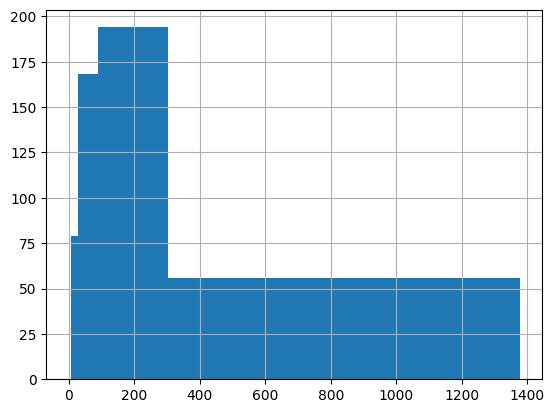

In [27]:
days_to_first_sale_bins = [0, seller_base_df.days_to_first_sale.min() ,30 ,90, seller_base_df.days_to_first_sale.mean() + std(seller_base_df.days_to_first_sale), seller_base_df.days_to_first_sale.max() +1 ]
seller_base_df.days_to_first_sale.hist(bins=days_to_first_sale_bins)

In [28]:
seller_base_df.days_to_first_sale.value_counts(bins=days_to_first_sale_bins)

(90.0, 304.154]      191
(30.0, 90.0]         168
(7.0, 30.0]          79 
(304.154, 1376.0]    56 
(-0.001, 7.0]        3  
Name: days_to_first_sale, dtype: int64

In [29]:
seller_base_df['days_to_first_sale'] = pd.cut(seller_base_df.days_to_first_sale, days_to_first_sale_bins).cat.codes
seller_base_df['days_to_first_sale'].value_counts()

-1    232
 3    191
 2    168
 1    79 
 4    56 
 0    3  
Name: days_to_first_sale, dtype: int64

# Offer Columns

In [30]:
seller_base_df.columns

Index(['date_created', 'months_with_conrad', 'is_fds', 'date_first_order',
       'days_to_first_sale', 'company_type', 'offers_active_mp_total',
       'offers_active_mp_ict', 'offers_active_mp_mro', 'offers_active_mp_bssa',
       ...
       'pdp_inactive_6m_bssa', 'pdp_inactive_6m_none',
       'pdp_inactive_12m_total', 'pdp_inactive_12m_ict',
       'pdp_inactive_12m_mro', 'pdp_inactive_12m_bssa',
       'pdp_inactive_12m_none', 'shop_state_cat_CLOSE', 'shop_state_cat_OPEN',
       'shop_state_cat_SUSPENDED'],
      dtype='object', length=329)

In [31]:
periodic_cols = ['purchased_products_oci_3m_total',
 'purchased_offers_oci_6m_mro',
 'orders_oci_1m_mro',
 'sales_oci_3m_total',
 'purchased_offers_mp_3m_mro',
 'sales_oci_12m_mro',
 'orders_mp_6m_mro',
 'orders_oci_12m_none',
 'purchased_products_mp_1m_bssa',
 'purchased_offers_oci_1m_mro',
 'sales_mp_12m_mro',
 'sales_oci_12m_total',
 'sales_mp_1m_total',
 'customers_oci_6m_total',
 'commmission_mp_6m_mro',
 'purchased_offers_oci_1m_ict',
 'pdp_inactive_6m_mro',
 'sales_mp_6m_total',
 'customers_oci_6m_bssa',
 'purchased_offers_oci_12m_ict',
 'orders_mp_1m_mro',
 'purchased_offers_oci_3m_total',
 'purchased_offers_mp_1m_bssa',
 'customers_mp_1m_bssa',
 'orders_oci_6m_mro',
 'orders_oci_12m_ict',
 'purchased_offers_oci_6m_ict',
 'purchased_offers_oci_1m_total',
 'sales_mp_6m_mro',
 'sales_oci_1m_ict',
 'pdp_inactive_12m_none',
 'customers_oci_3m_mro',
 'pdp_active_12m_bssa',
 'pdp_active_1m_ict',
 'purchased_offers_oci_12m_total',
 'purchased_products_oci_12m_total',
 'orders_mp_3m_total',
 'commmission_mp_3m_ict',
 'purchased_products_oci_1m_mro',
 'purchased_products_oci_1m_ict',
 'orders_mp_12m_none',
 'pdp_inactive_6m_ict',
 'purchased_products_oci_1m_total',
 'ordered_units_mp_3m_total',
 'pdp_inactive_12m_total',
 'purchased_offers_mp_6m_ict',
 'pdp_active_6m_total',
 'orders_mp_6m_bssa',
 'orders_mp_3m_mro',
 'orders_mp_3m_ict',
 'pdp_inactive_6m_none',
 'commmission_mp_3m_mro',
 'pdp_active_3m_total',
 'customers_mp_12m_mro',
 'customers_mp_1m_total',
 'customers_mp_3m_bssa',
 'pdp_active_3m_bssa',
 'purchased_offers_oci_3m_ict',
 'orders_mp_12m_mro',
 'customers_mp_6m_mro',
 'purchased_products_mp_3m_ict',
 'purchased_products_oci_3m_mro',
 'sales_oci_12m_bssa',
 'commmission_mp_1m_ict',
 'customers_oci_12m_total',
 'orders_oci_3m_total',
 'pdp_inactive_1m_bssa',
 'orders_mp_12m_bssa',
 'purchased_products_mp_1m_total',
 'purchased_offers_mp_12m_bssa',
 'customers_mp_12m_bssa',
 'pdp_inactive_1m_mro',
 'sales_mp_3m_mro',
 'customers_oci_1m_ict',
 'purchased_offers_oci_6m_total',
 'customers_mp_12m_total',
 'purchased_products_mp_12m_total',
 'commmission_mp_12m_ict',
 'sales_mp_12m_none',
 'pdp_inactive_3m_mro',
 'pdp_inactive_3m_none',
 'orders_oci_1m_ict',
 'orders_oci_1m_bssa',
 'sales_oci_6m_mro',
 'sales_mp_3m_bssa',
 'purchased_offers_mp_12m_ict',
 'pdp_inactive_1m_none',
 'pdp_inactive_6m_total',
 'ordered_units_oci_12m_total',
 'orders_mp_1m_total',
 'purchased_offers_mp_12m_mro',
 'customers_mp_3m_mro',
 'pdp_inactive_3m_total',
 'customers_oci_3m_bssa',
 'commmission_mp_3m_total',
 'orders_mp_12m_total',
 'purchased_products_oci_3m_ict',
 'customers_mp_6m_ict',
 'orders_oci_6m_bssa',
 'ordered_units_mp_6m_total',
 'purchased_products_mp_6m_mro',
 'customers_oci_3m_total',
 'pdp_inactive_3m_ict',
 'sales_mp_12m_total',
 'customers_mp_12m_none',
 'commmission_mp_12m_bssa',
 'purchased_products_oci_12m_mro',
 'purchased_offers_mp_6m_bssa',
 'customers_mp_3m_total',
 'pdp_active_6m_mro',
 'orders_mp_12m_ict',
 'purchased_products_oci_6m_ict',
 'purchased_offers_oci_3m_bssa',
 'commmission_mp_6m_total',
 'customers_oci_1m_total',
 'customers_mp_12m_ict',
 'purchased_products_mp_1m_ict',
 'orders_mp_6m_ict',
 'orders_oci_12m_total',
 'customers_oci_1m_mro',
 'pdp_active_12m_ict',
 'sales_mp_6m_ict',
 'purchased_products_mp_6m_total',
 'orders_oci_6m_total',
 'pdp_inactive_1m_total',
 'pdp_active_12m_mro',
 'purchased_products_mp_6m_ict',
 'customers_mp_1m_mro',
 'sales_oci_6m_bssa',
 'commmission_mp_1m_total',
 'purchased_products_oci_6m_mro',
 'pdp_active_1m_total',
 'pdp_active_12m_none',
 'purchased_offers_mp_3m_total',
 'purchased_offers_mp_1m_ict',
 'sales_mp_3m_ict',
 'purchased_products_mp_12m_ict',
 'ordered_units_mp_3m_none',
 'purchased_offers_mp_3m_bssa',
 'purchased_products_mp_1m_mro',
 'customers_oci_12m_mro',
 'ordered_units_mp_12m_total',
 'purchased_offers_mp_6m_mro',
 'ordered_units_mp_12m_bssa',
 'commmission_mp_6m_ict',
 'purchased_products_oci_12m_ict',
 'pdp_active_6m_none',
 'orders_mp_6m_none',
 'purchased_products_oci_12m_bssa',
 'orders_oci_12m_bssa',
 'purchased_offers_oci_1m_bssa',
 'customers_mp_1m_ict',
 'purchased_products_mp_3m_bssa',
 'purchased_offers_oci_3m_mro',
 'pdp_inactive_1m_ict',
 'pdp_inactive_6m_bssa',
 'pdp_inactive_3m_bssa',
 'pdp_inactive_12m_ict',
 'pdp_active_3m_ict',
 'commmission_mp_6m_bssa',
 'pdp_inactive_12m_mro',
 'sales_oci_6m_ict',
 'purchased_offers_mp_1m_mro',
 'orders_oci_1m_total',
 'pdp_active_1m_none',
 'purchased_products_mp_6m_bssa',
 'orders_oci_3m_mro',
 'customers_mp_3m_ict',
 'customers_mp_6m_bssa',
 'sales_oci_3m_mro',
 'sales_mp_12m_ict',
 'pdp_active_3m_mro',
 'purchased_offers_mp_12m_none',
 'sales_mp_1m_mro',
 'pdp_active_6m_ict',
 'purchased_offers_mp_3m_ict',
 'commmission_mp_12m_mro',
 'purchased_products_mp_12m_mro',
 'orders_mp_3m_bssa',
 'customers_oci_6m_ict',
 'sales_oci_3m_bssa',
 'orders_oci_3m_ict',
 'purchased_offers_oci_12m_mro',
 'ordered_units_mp_12m_ict',
 'pdp_active_6m_bssa',
 'purchased_offers_oci_6m_bssa',
 'purchased_offers_mp_12m_total',
 'purchased_products_mp_3m_mro',
 'commmission_mp_12m_total',
 'customers_oci_12m_bssa',
 'sales_oci_1m_total',
 'orders_oci_3m_bssa',
 'sales_oci_6m_total',
 'orders_mp_1m_bssa',
 'pdp_active_12m_total',
 'orders_oci_6m_ict',
 'purchased_products_mp_12m_bssa',
 'sales_mp_12m_bssa',
 'purchased_products_oci_6m_total',
 'pdp_active_1m_bssa',
 'sales_oci_3m_ict',
 'purchased_products_oci_3m_bssa',
 'purchased_products_oci_6m_bssa',
 'orders_mp_6m_total',
 'orders_oci_12m_mro',
 'pdp_active_1m_mro',
 'sales_mp_1m_ict',
 'ordered_units_mp_6m_mro',
 'purchased_products_oci_1m_bssa',
 'ordered_units_mp_6m_ict',
 'customers_oci_3m_ict',
 'purchased_offers_mp_6m_total',
 'pdp_inactive_12m_bssa',
 'sales_oci_12m_ict',
 'pdp_active_3m_none',
 'sales_mp_1m_bssa',
 'purchased_offers_oci_12m_bssa',
 'purchased_offers_mp_1m_total',
 'ordered_units_mp_12m_mro',
 'sales_mp_6m_bssa',
 'customers_oci_6m_mro',
 'customers_mp_6m_total',
 'sales_mp_3m_total',
 'customers_oci_12m_ict',
 'orders_mp_1m_ict',
 'purchased_products_mp_12m_none',
 'purchased_products_mp_3m_total',
 'customers_oci_1m_bssa']

In [32]:
exceptional_cols = ['ordered_units_mp_12m_none','ordered_units_mp_1m_ict', 'purchased_offers_oci_12m_none', 'ordered_units_oci_6m_total',
                   'purchased_products_oci_12m_none', 'purchased_products_oci_12m_none', 'ordered_units_mp_6m_none', 'customers_oci_3m_none',
                   'sales_oci_1m_mro', 'commmission_mp_1m_bssa', 'orders_oci_6m_none', 'ordered_units_oci_3m_total','orders_mp_1m_none',
                   'commmission_mp_12m_none', 'purchased_offers_oci_1m_none', 'ordered_units_mp_3m_mro', 'ordered_units_oci_3m_bssa',
                    'sales_oci_3m_none', 'ordered_units_oci_6m_ict', 'customers_oci_6m_none', 'ordered_units_oci_6m_mro', 'ordered_units_oci_6m_none',
                    'ordered_units_oci_3m_ict', 'ordered_units_oci_12m_bssa', 'ordered_units_mp_1m_none', 'ordered_units_mp_1m_bssa',
                    'customers_oci_1m_none', 'ordered_units_oci_3m_none', 'customers_mp_3m_none', 'purchased_products_mp_3m_none', 'ordered_units_oci_1m_none',
                    'ordered_units_oci_12m_ict', 'ordered_units_mp_1m_total', 'commmission_mp_1m_mro', 'purchased_offers_oci_6m_none',
                    'sales_oci_1m_bssa', 'sales_oci_1m_none', 'purchased_products_oci_3m_none', 'customers_mp_6m_none', 'ordered_units_mp_3m_bssa',
                    'sales_oci_12m_none', 'ordered_units_oci_6m_bssa', 'customers_mp_1m_none', 'commmission_mp_3m_bssa',
                    'purchased_offers_mp_1m_none', 'sales_mp_6m_none', 'purchased_products_oci_1m_none', 'commmission_mp_6m_none', 'orders_mp_3m_none',
                    'ordered_units_mp_6m_bssa', 'orders_oci_3m_none', 'ordered_units_oci_3m_mro', 'ordered_units_oci_12m_mro',
                    'sales_oci_6m_none', 'sales_mp_3m_none', 'commmission_mp_3m_none', 'purchased_products_oci_6m_none', 'ordered_units_oci_12m_none',
                    'ordered_units_oci_1m_total', 'purchased_offers_oci_3m_none', 'customers_oci_12m_none', 'ordered_units_oci_1m_ict',
                    'purchased_products_mp_6m_none', 'sales_mp_1m_none', 'ordered_units_oci_1m_bssa', 'commmission_mp_1m_none', 'ordered_units_mp_3m_ict',
                    'ordered_units_oci_1m_mro', 'purchased_offers_mp_3m_none', 'purchased_products_mp_1m_none', 'purchased_offers_mp_6m_none']


In [33]:
exceptional_cols = sorted(exceptional_cols)
#print(sorted(exceptional_cols))

In [34]:
exceptional_cols = ['commmission_mp_1m_bssa', 'commmission_mp_3m_bssa', 
                    'commmission_mp_1m_mro', 
                    'commmission_mp_1m_none', 'commmission_mp_3m_none', 'commmission_mp_6m_none', 'commmission_mp_12m_none', 
                    'ordered_units_mp_1m_bssa', 'ordered_units_mp_3m_bssa', 'ordered_units_mp_6m_bssa', 
                    'ordered_units_mp_1m_ict', 'ordered_units_mp_3m_ict', 
                    'ordered_units_mp_3m_mro', 
                    'ordered_units_mp_6m_none', 'ordered_units_mp_12m_none', 
                    'ordered_units_mp_1m_total', 
                    'ordered_units_oci_1m_bssa', 'ordered_units_oci_3m_bssa', 'ordered_units_oci_6m_bssa', 'ordered_units_oci_12m_bssa', 
                    'ordered_units_oci_1m_ict', 'ordered_units_oci_3m_ict', 'ordered_units_oci_6m_ict', 'ordered_units_oci_12m_ict', 
                    'ordered_units_oci_1m_mro', 'ordered_units_oci_3m_mro', 'ordered_units_oci_6m_mro', 'ordered_units_oci_12m_mro',  
                    'ordered_units_oci_1m_total', 'ordered_units_oci_3m_total', 'ordered_units_oci_6m_total',
                    'sales_mp_1m_none', 'sales_mp_3m_none', 'sales_mp_6m_none', 
                    'sales_oci_1m_bssa', 
                    'sales_oci_12m_none', 
                    'sales_oci_1m_mro', 
                    'sales_oci_1m_none', 'sales_oci_3m_none', 'sales_oci_6m_none']


In [35]:
seller_base_df['commmission_mp_1m_bssa'].min(), seller_base_df['commmission_mp_1m_bssa'].mean(), std(seller_base_df['commmission_mp_1m_bssa']), seller_base_df['commmission_mp_1m_bssa'].max()
                                                                                                            

(0.0, 162.93061728395062, 820.8733602193008, 14152.51)

In [36]:
seller_base_df['commmission_mp_1m_bssa'].mean()

162.93061728395062

In [37]:
print(np.asarray(seller_base_df['commmission_mp_1m_bssa'], dtype=np.float).mean())


162.93061728395062


/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


CPU times: user 2.73 s, sys: 2.19 ms, total: 2.74 s
Wall time: 2.9 s


,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,orders_mp_6m_ict,order

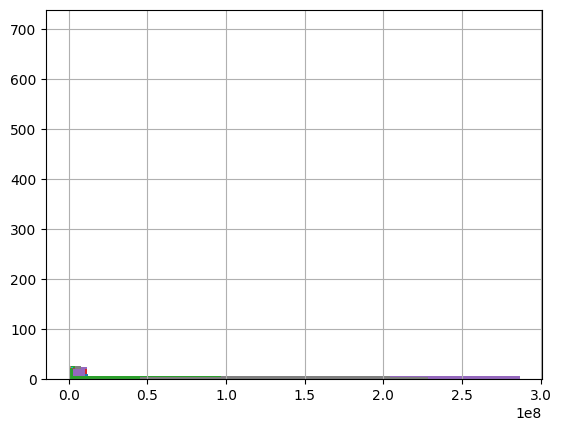

In [38]:
%%time
for col in periodic_cols:
    #print(col)
    offer_bins = [seller_base_df[col].min(),1, seller_base_df[col].mean(), seller_base_df[col].mean() + std(seller_base_df[col]), seller_base_df[col].max() +1 ]
    seller_base_df[col].hist(bins=offer_bins)
    seller_base_df[col] = pd.cut(seller_base_df[col], offer_bins).cat.codes
seller_base_df.head()

In [39]:
seller_base_df['commmission_mp_1m_bssa'].min(),1, np.asarray(seller_base_df['commmission_mp_1m_bssa'], dtype=np.float).mean(), seller_base_df['commmission_mp_1m_bssa'].max()


/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(0.0, 1, 162.93061728395062, 14152.51)

/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


commmission_mp_1m_bssa
commmission_mp_3m_bssa
commmission_mp_1m_mro
commmission_mp_1m_none
commmission_mp_3m_none
commmission_mp_6m_none
commmission_mp_12m_none
ordered_units_mp_1m_bssa
ordered_units_mp_3m_bssa
ordered_units_mp_6m_bssa
ordered_units_mp_1m_ict
ordered_units_mp_3m_ict
ordered_units_mp_3m_mro
ordered_units_mp_6m_none
ordered_units_mp_12m_none
ordered_units_mp_1m_total
ordered_units_oci_1m_bssa
ordered_units_oci_3m_bssa
ordered_units_oci_6m_bssa
ordered_units_oci_12m_bssa
ordered_units_oci_1m_ict
ordered_units_oci_3m_ict
ordered_units_oci_6m_ict
ordered_units_oci_12m_ict
ordered_units_oci_1m_mro
ordered_units_oci_3m_mro
ordered_units_oci_6m_mro
ordered_units_oci_12m_mro
ordered_units_oci_1m_total
ordered_units_oci_3m_total
ordered_units_oci_6m_total
sales_mp_1m_none
sales_mp_3m_none
sales_mp_6m_none
sales_oci_1m_bssa
sales_oci_12m_none
sales_oci_1m_mro
sales_oci_1m_none
sales_oci_3m_none
sales_oci_6m_none
CPU times: user 292 ms, sys: 11.5 ms, total: 304 ms
Wall time: 297 m

,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,orders_mp_6m_ict,order

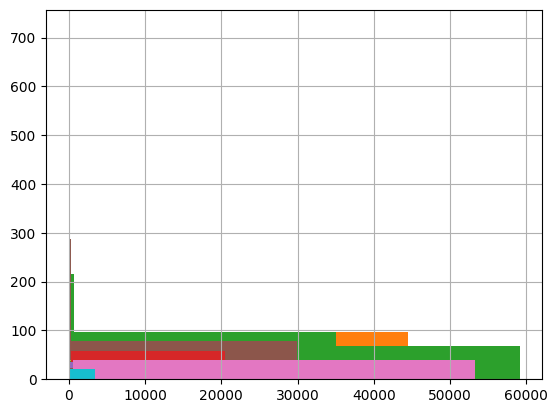

In [40]:
%%time
for col in exceptional_cols:
    print(col)
    offer_bins = [seller_base_df[col].min(),1, np.asarray(seller_base_df[col], dtype=np.float).mean(), seller_base_df[col].max() +1 ]
    seller_base_df[col].hist(bins=offer_bins)
    seller_base_df[col] = pd.cut(seller_base_df[col], offer_bins).cat.codes
seller_base_df.head()

In [41]:
exceptional_cols2 = ['customers_mp_1m_none', 'customers_mp_3m_none', 'customers_mp_6m_none',
                     'customers_oci_1m_none', 'customers_oci_3m_none', 'customers_oci_6m_none', 'customers_oci_12m_none',
                     'ordered_units_mp_1m_none',
                     'ordered_units_oci_1m_none', 'ordered_units_oci_3m_none', 'ordered_units_oci_6m_none', 'ordered_units_oci_12m_none',
                     'orders_mp_1m_none', 'orders_mp_3m_none', 
                     'orders_oci_3m_none', 'orders_oci_6m_none',
                     'purchased_offers_mp_1m_none', 'purchased_offers_mp_3m_none', 'purchased_offers_mp_6m_none', 
                     'purchased_offers_oci_1m_none', 'purchased_offers_oci_3m_none', 'purchased_offers_oci_6m_none', 'purchased_offers_oci_12m_none', 
                     'purchased_products_mp_1m_none', 'purchased_products_mp_3m_none', 'purchased_products_mp_6m_none', 
                     'purchased_products_oci_1m_none', 'purchased_products_oci_3m_none', 'purchased_products_oci_6m_none', 'purchased_products_oci_12m_none'
]

customers_mp_1m_none
customers_mp_3m_none
customers_mp_6m_none
customers_oci_1m_none
customers_oci_3m_none
customers_oci_6m_none
customers_oci_12m_none
ordered_units_mp_1m_none
ordered_units_oci_1m_none
ordered_units_oci_3m_none
ordered_units_oci_6m_none
ordered_units_oci_12m_none
orders_mp_1m_none
orders_mp_3m_none
orders_oci_3m_none
orders_oci_6m_none
purchased_offers_mp_1m_none
purchased_offers_mp_3m_none
purchased_offers_mp_6m_none
purchased_offers_oci_1m_none
purchased_offers_oci_3m_none
purchased_offers_oci_6m_none
purchased_offers_oci_12m_none
purchased_products_mp_1m_none
purchased_products_mp_3m_none
purchased_products_mp_6m_none
purchased_products_oci_1m_none
purchased_products_oci_3m_none
purchased_products_oci_6m_none
purchased_products_oci_12m_none
CPU times: user 211 ms, sys: 0 ns, total: 211 ms
Wall time: 208 ms


/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,orders_mp_6m_ict,order

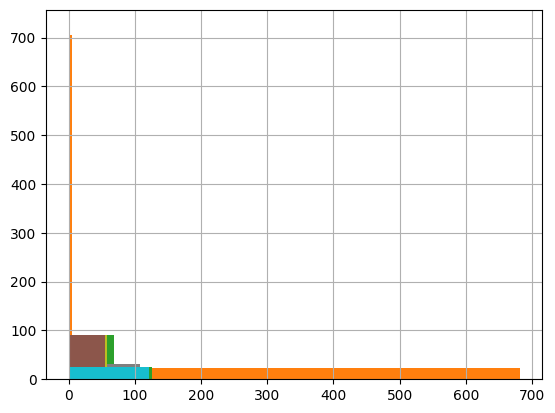

In [42]:
%%time
for col in exceptional_cols2:
    print(col)
    offer_bins = [seller_base_df[col].min(), np.asarray(seller_base_df[col], dtype=np.float).mean(), seller_base_df[col].max() +1 ]
    seller_base_df[col].hist(bins=offer_bins)
    seller_base_df[col] = pd.cut(seller_base_df[col], offer_bins).cat.codes
seller_base_df.head()

In [43]:
for col in boolean_cols:
    seller_base_df[col].fillna("Other", inplace=True)
    seller_base_df[col] = seller_base_df[col].map(boolean_dict)
    seller_base_df[col].value_counts()

In [44]:
seller_base_df['is_fds'].value_counts()

0    654
1    75 
Name: is_fds, dtype: int64

In [45]:
for col in seller_base_df.select_dtypes(include=['dbdate']).columns:
    print(col)
    seller_base_df[col].replace({np.nan: '1999-01-01'}, inplace = True)
    seller_base_df[col] = pd.to_datetime(seller_base_df[col])

date_created
date_first_order


In [46]:
seller_base_df["date_created_day"] = seller_base_df['date_created'].map(lambda x: x.day)
seller_base_df["date_created_month"] = seller_base_df['date_created'].map(lambda x: x.month)
seller_base_df["date_created_year"] = seller_base_df['date_created'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_created"], axis=1, inplace=True)
##############
seller_base_df["date_first_order_day"] = seller_base_df['date_first_order'].map(lambda x: x.day)
seller_base_df["date_first_order_month"] = seller_base_df['date_first_order'].map(lambda x: x.month)
seller_base_df["date_first_order_year"] = seller_base_df['date_first_order'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_first_order"], axis=1, inplace=True)

# company_type

In [47]:
seller_base_df['company_type'].unique()

array(['Co. KG', 'other', 'GmbH', 'AG'], dtype=object)

In [48]:
company_type_dictionary = dict(zip(seller_base_df['company_type'].unique() , np.arange(1, len(seller_base_df['company_type'].unique()) + 1, 1).tolist()))
seller_base_df['company_type'] = seller_base_df['company_type'].map(company_type_dictionary)
seller_base_df['company_type'].nunique()

4

# KMeans Clustering

In [49]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
K = range(5,21)

In [50]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [ ]:
for k in K:
    clf = KMeansConstrained(
             n_clusters=k,
             size_min=20,
             size_max=200,
             random_state=20
    )
    clf.fit_predict(seller_base_df)
    #print(color.BOLD + str(k) + color.END)
    print(Counter(clf.labels_))
    silhouette_avg_kmeans = silhouette_score(seller_base_df, clf.labels_)
    print(color.BOLD + "For n_clusters =", str(clf.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

In [51]:
clf_5 = KMeansConstrained(
             n_clusters=5,
             size_min=20,
             size_max=170,
             random_state=20
)
clf_5.fit_predict(seller_base_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf_5.labels_))
silhouette_avg_kmeans = silhouette_score(seller_base_df, clf_5.labels_)
print(color.BOLD + "For n_clusters =", str(clf_5.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({1: 170, 4: 170, 3: 170, 0: 170, 2: 49})
For n_clusters = 5 The average silhouette_score is : -0.0953767404523327


In [52]:
clf_6 = KMeansConstrained(
             n_clusters=6,
             size_min=20,
             size_max=170,
             random_state=20
)
clf_6.fit_predict(seller_base_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf_6.labels_))
silhouette_avg_kmeans = silhouette_score(seller_base_df, clf_6.labels_)
print(color.BOLD + "For n_clusters =", str(clf_6.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({1: 170, 2: 170, 0: 170, 4: 170, 5: 29, 3: 20})
For n_clusters = 6 The average silhouette_score is : -0.0902069194199189


In [53]:
clf_7 = KMeansConstrained(
             n_clusters=7,
             size_min=20,
             size_max=170,
             random_state=20
)
clf_7.fit_predict(seller_base_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf_7.labels_))
silhouette_avg_kmeans = silhouette_score(seller_base_df, clf_7.labels_)
print(color.BOLD + "For n_clusters =", str(clf_7.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({6: 170, 3: 170, 2: 170, 0: 144, 1: 35, 4: 20, 5: 20})
For n_clusters = 7 The average silhouette_score is : -0.0569223031737791


In [54]:
#seller_base_df['seller_segments'] = clf.labels_
seller_df_5 = seller_df.copy()
seller_df_5['seller_segments'] = clf_5.labels_

seller_df_6 = seller_df.copy()
seller_df_6['seller_segments'] = clf_6.labels_

seller_df_7 = seller_df.copy()
seller_df_7['seller_segments'] = clf_7.labels_



/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

In [58]:
seller_df_7.head()

,shop_id,shop_state,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,ord

In [59]:
seller_df_7.columns

Index(['shop_id', 'shop_state', 'date_created', 'months_with_conrad', 'is_fds',
       'date_first_order', 'days_to_first_sale', 'company_type',
       'offers_active_mp_total', 'offers_active_mp_ict',
       ...
       'pdp_inactive_6m_ict', 'pdp_inactive_6m_mro', 'pdp_inactive_6m_bssa',
       'pdp_inactive_6m_none', 'pdp_inactive_12m_total',
       'pdp_inactive_12m_ict', 'pdp_inactive_12m_mro', 'pdp_inactive_12m_bssa',
       'pdp_inactive_12m_none', 'seller_segments'],
      dtype='object', length=329)

In [60]:
for seg in seller_df_7.seller_segments.unique():
    print(seg, ':')
    print(seller_df_7[seller_df_7.seller_segments == seg].days_to_first_sale.mean())

6 :
162.57264957264957
4 :
118.25
3 :
<NA>
2 :
145.0
0 :
141.02142857142857
1 :
116.77142857142857
5 :
82.85


In [63]:
int_corr = seller_df_7.corr()
cr = int_corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.1
top_corr_columns = cr.loc[:, 'seller_segments'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.065].sort_values(ascending=False)
len(best_accurate_columns)

11

In [64]:
best_accurate_columns

offers_inactive_mp_mro             0.069216
offers_inactive_mp_none            0.068077
offers_active_oci_total            0.067993
customers_oci_12m_none             0.067509
orders_oci_12m_none                0.067334
purchased_offers_oci_12m_none      0.066832
offers_active_oci_mro              0.066621
purchased_products_oci_12m_none    0.066505
purchased_products_mp_6m_none     -0.065626
ordered_units_mp_6m_none          -0.073445
is_fds                            -0.153583
Name: seller_segments, dtype: float64

In [67]:
# TODO(developer): Set table_id to the ID of the table to fetch.

table_id_5 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_5'
table_id_6 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_6'
table_id_7 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_7'

table_list = [table_id_5, table_id_6, table_id_7]
seller_list = [seller_df_5, seller_df_6, seller_df_7]

for table in table_list:
    bqclient.delete_table(table, not_found_ok=True)  # Make an API request.
    print("Deleted table '{}'.".format(table))
    
# Load data to BQ
job = bqclient.load_table_from_dataframe(seller_df_5, table_id_5)
print("Table created '{}'.".format(table_id_5))

job = bqclient.load_table_from_dataframe(seller_df_6, table_id_6)
print("Table created '{}'.".format(table_id_6))

job = bqclient.load_table_from_dataframe(seller_df_7, table_id_7)
print("Table created '{}'.".format(table_id_7))



Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_5'.
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_6'.
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_7'.
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_5'.
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_6'.
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_7'.


In [65]:

# TODO(developer): Set table_id to the ID of the table to fetch.
table_id_0 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_0'
table_id_1 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_1'
table_id_2 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_2'
table_id_3 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_3'
table_id_4 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_4'
table_id_5 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_5'
table_id_6 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_6'

table_list = [table_id_0, table_id_1, table_id_2, table_id_3, table_id_4, table_id_5, table_id_6]

# If the table does not exist, delete_table raises
# google.api_core.exceptions.NotFound unless not_found_ok is True.
k = 0
for table in table_list:
    print(table)
    bqclient.delete_table(table, not_found_ok=True)  # Make an API request.
    print("Deleted table '{}'.".format(table))
    # Load data to BQ
    #print(k)
    #job = bqclient.load_table_from_dataframe(seller_df[seller_df.seller_segments == k], table)
    #k += 1
    

ps-analytics-prod.eser.seller_segment_results_iteration_3_k_0
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_0'.
ps-analytics-prod.eser.seller_segment_results_iteration_3_k_1
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_1'.
ps-analytics-prod.eser.seller_segment_results_iteration_3_k_2
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_2'.
ps-analytics-prod.eser.seller_segment_results_iteration_3_k_3
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_3'.
ps-analytics-prod.eser.seller_segment_results_iteration_3_k_4
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_4'.
ps-analytics-prod.eser.seller_segment_results_iteration_3_k_5
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_5'.
ps-analytics-prod.eser.seller_segment_results_iteration_3_k_6
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_6'.
